### Optimal control of oscillations and synchrony in the Wilson-Cowan model
This notebook shows how to compute the optimal control (OC) signal for the Wilson-Cowan model for an oscillation and a synchronization task.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import networkx as nx

while os.getcwd().split(os.sep)[-1] != "neurolib":
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.wc import WCModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.control.optimal_control import oc_wc

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

In [2]:
# We define plot functions for the control tasks

def plot_osc_singlenode(
    duration,
    dt,
    state,
    target_period,
    control,
    cost_array=(),
):
    """Plot target and controlled dynamics for a single node.
    :param duration:        Duration of simulation (in ms).
    :type duration:         float
    :param dt:              Time discretization (in ms).
    :type dt:               float
    :param state:           The state of the system controlled with the found oc-input.
    :type state:            np.ndarray
    :param target_period:   The target state.
    :type target_period:    np.ndarray
    :param control:         The control signal found by the oc-algorithm.
    :type control:          np.ndarray
    :param cost_array:      Array of costs in optimization iterations.
    :type cost_array:       np.ndarray, optional

    """
    fig, ax = plt.subplots(3, 1, figsize=(8, 6), constrained_layout=True)

    # Plot the target (dashed line) and unperturbed activity
    t_array = np.arange(0, duration + dt, dt)

    # Plot the controlled state and
    ax[0].plot(t_array, state[0, 0, :], label="E", color="red")
    ax[0].plot(t_array, state[0, 1, :], label="I", color="blue")

    for k in range(int(np.floor(duration/(2*target_period)))):
        ax[0].fill_between([2*k*target_period,(2*k+1)*target_period], y1=-0.05, y2=0.55, color="gray", alpha=0.5)

    ax[0].legend(loc="upper right")
    ax[0].set_ylabel("Activity")
    ax[0].set_xlim(0,duration)
    ax[0].set_xticks([])
    ax[0].set_ylim(-0.05, 0.55)

    # Plot the computed control signal and the initial/ original control signal (dashed line)
    ax[1].plot(t_array, control[0, 0, :], label="E", color="red")
    ax[1].plot(t_array, control[0, 1, :], label="I", color="blue")
    ax[1].legend(loc="upper right")
    ax[1].set_ylabel("Control")
    ax[1].set_xlim(0,duration)
    ax[1].set_xlabel("Time")

    ax[2].plot(cost_array)
    ax[2].set_xlim(0,len(cost_array))
    ax[2].set_ylabel("Cost throughout optimization")
    ax[2].set_ylabel("Iterations")

    plt.show()

def plot_osc_nw(
    duration,
    dt,
    state,
    control,
    N,
    cost_array=(),
):
    """Plot target and controlled dynamics for a single node.
    :param duration:        Duration of simulation (in ms).
    :type duration:         float
    :param dt:              Time discretization (in ms).
    :type dt:               float
    :param state:           The state of the system controlled with the found oc-input.
    :type state:            np.ndarray
    :param control:         The control signal found by the oc-algorithm.
    :type control:          np.ndarray
    :params N:              Number of nodes
    :type N:                int
    :param cost_array:      Array of costs in optimization iterations.
    :type cost_array:       np.ndarray, optional

    """
    fig, ax = plt.subplots(3, 1, figsize=(8, 6), constrained_layout=True)

    # Plot the target (dashed line) and unperturbed activity
    t_array = np.arange(0, duration + dt, dt)

    # Plot the controlled state and
    for n in range(N):
        ax[0].plot(t_array, state[n, 0, :])

    ax[0].set_ylabel("Exc activity")
    ax[0].set_xlim(0,duration)
    ax[0].set_xticks([])

    # Plot the computed control signal and the initial/ original control signal (dashed line)
    for n in range(N):
        ax[1].plot(t_array, control[n, 0, :])
    ax[1].set_ylabel("Exc control")
    ax[1].set_xlim(0,duration)
    ax[1].set_xlabel("Time")

    ax[2].plot(cost_array)
    ax[2].set_xlim(0,len(cost_array))
    ax[2].set_ylabel("Cost throughout optimization")
    ax[2].set_ylabel("Iterations")

    plt.show()

options = {
    'node_color': 'lightgray',
    'node_size': 1000,
    'width': 2,
    'arrowstyle': '-|>',
    'arrowsize': 20,
    'font_size' : 20,
    'font_weight' : 'bold',
    }

def draw_nwgraph(cmat):
    G = nx.DiGraph() 
    for n in range(cmat.shape[0]):
            for l in range(cmat.shape[1]):
                if cmat[n,l] != 0:
                    G.add_edge(l,n)
    nx.draw(G, with_labels=True, arrows=True, **options)
    plt.show()

### Synchronization task: Cross-correlation cost and variance cost

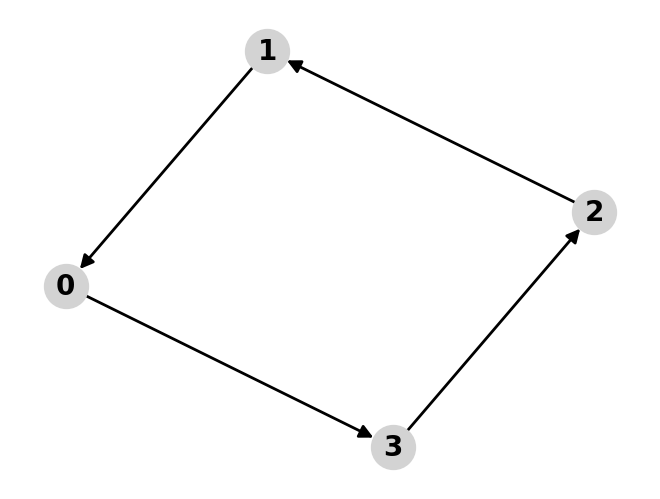

In [82]:
# generate random 4-node network
# different networks are differently easy or difficult to synchronize. Re-run the generation to study this effect, change parameters "p_connect" and "delay_factor"
N = 4

p_connect = 0.4 # probability that nodes are connected
delay_factor = 0.

p_inv = 1. - p_connect
cmat = np.random.choice([0, 1], size=(N,N), p=[p_inv, p_connect])
for n in range(N):
    cmat[n, n] = 0

cmat = np.zeros((N,N))
cmat[0,1] = 1.
cmat[1,2] = 1.
cmat[2,3] = 1
cmat[3,0] = 1

dmat = np.random.random((N, N))
for n1 in range(N):
    for n2 in range(N):
        dmat[n1, n2] *= delay_factor * cmat[n1,n2]

draw_nwgraph(cmat)





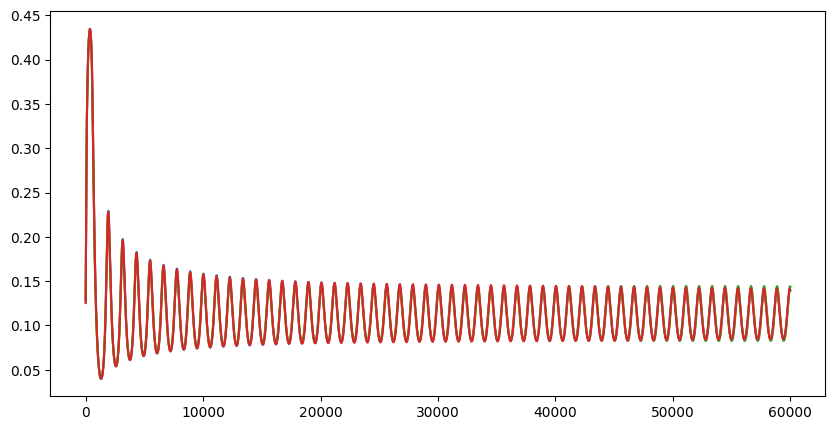

In [88]:
model = WCModel(Cmat=cmat, Dmat=dmat)
duration = 600
dt = 0.01

# we define the control input matrix to enable or disable certain channels and nodes
control_mat = np.zeros( (model.params.N, len(model.state_vars)) )
control_mat[:,0] = 1. # only allow inputs in exc-channels
model.params["duration"] = 0.2 * duration
model.params.dt = dt

model.params["exc_ext_baseline"] = 2. # go into oscillatory region
model.params["inh_ext_baseline"] = 1.

# We set the duration of the simulation and the initial values
model.params["duration"] = duration
model.params.K_gl = 0.3     # default: 0.6

zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = zero_input.copy()
input[:,:100] = 5.
model.params.exc_ext = input

model.run()

model.params["duration"] = duration
# for reproducibility, fix initial conditions
model.params["exc_init"] = np.vstack([model.exc[0,-1], model.exc[1,-1], model.exc[2,-1], model.exc[3,-1]])
model.params["inh_init"] = np.vstack([model.inh[0,-1], model.inh[1,-1], model.inh[2,-1], model.inh[3,-1]])



# We set the stimulus in x and y variables, and run the simulation
zero_input_nw = np.concatenate( (np.vstack( [zero_input, zero_input] )[np.newaxis,:,:],
                                 np.vstack( [zero_input, zero_input] )[np.newaxis,:,:]), axis=0)

model.run()

plt.figure(figsize=(10,5))
for n in range(N):
    plt.plot(model.exc[n,:])

plt.show()

Start with cross-correlation cost functional

Optimal control with target oscillation period


/tmp/ipykernel_101017/3208925738.py:103: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax[2].set_xlim(0,len(cost_array))


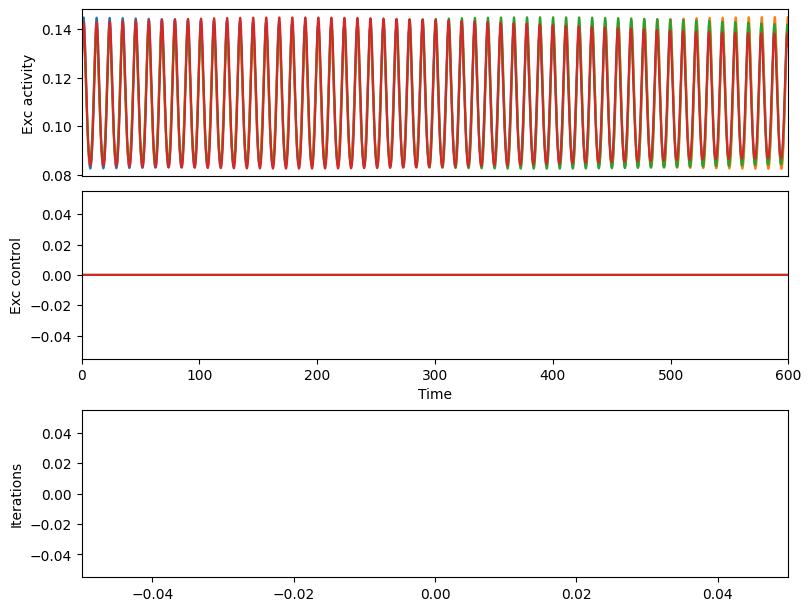

In [90]:
# we define the precision matrix to specify, in which nodes and channels we measure deviations from the target
cost_mat = np.zeros( (model.params.N, len(model.output_vars)) )
cost_mat[:,0] = 1. # only measure in x-channel in all nodes

# We set the external stimulation to zero. This is the "initial guess" for the OC algorithm
model.params["exc_ext"] = zero_input_nw[:,0,:]
model.params["inh_ext"] = zero_input_nw[:,0,:]

# We load the optimal control class
# print array (optional parameter) defines, for which iterations intermediate results will be printed
# Parameters will be taken from the input model
model_controlled = oc_wc.OcWc(model, 0, print_array=np.arange(0,101,10), control_matrix=control_mat, cost_matrix=cost_mat, control_interval=(1000, None), cost_interval=(1000, None))
model_controlled.weights["w_p"] = 0.
model_controlled.weights["w_2"] = 10.
model_controlled.weights["w_cc"] = -1.
model_controlled.channelwise_optimization = True

# We run 500 iterations of the optimal control gradient descent algorithm
#model_controlled.optimize(100)

state = model_controlled.get_xs()
control = model_controlled.control

plot_osc_nw(duration, dt, state, control, N, cost_array=model_controlled.cost_history)

Compute control for a deterministic system
Cost in iteration 0: -66.9695467293816
Cost in iteration 10: -67.38353321432878
Cost in iteration 20: -67.66635256338752
Cost in iteration 30: -68.73449301585858
Cost in iteration 40: -69.36913716207945
Cost in iteration 50: -70.13266883182587
Cost in iteration 60: -70.42390943413952
Cost in iteration 70: -71.46154382003495
Cost in iteration 80: -71.80021894578654
Cost in iteration 90: -72.25070144203092
Cost in iteration 100: -72.7277556435215
Final cost : -72.7277556435215


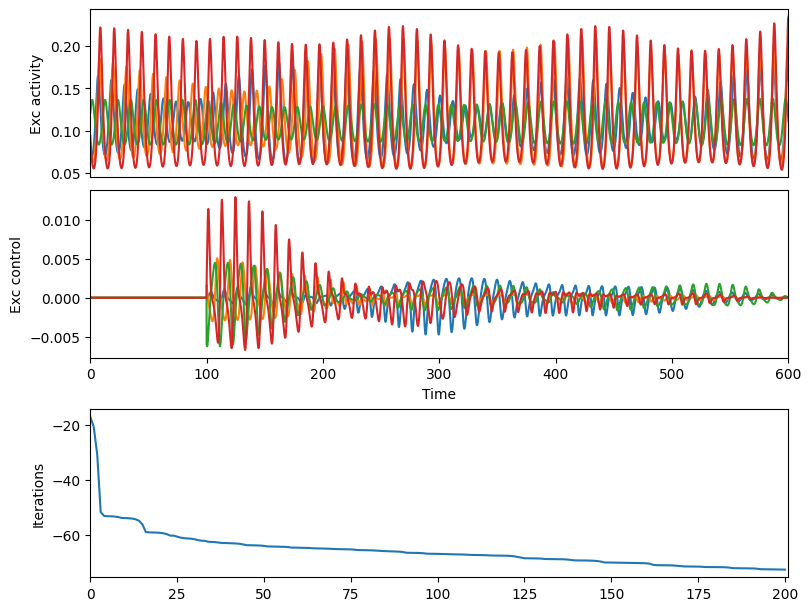

In [53]:
# Do another 100 iterations if you want to.
# Repeated execution will continue with further 100 iterations.
model_controlled.print_array=np.arange(0,101,10)
model_controlled.zero_step_encountered = False
model_controlled.grad_method = 0
#model_controlled.channelwise_optimization = True
#model_controlled.weights["w_2"] = 10.

model_controlled.optimize(100)
state = model_controlled.get_xs()
control = model_controlled.control
plot_osc_nw(duration, dt, state, control, N, cost_array=model_controlled.cost_history)

Variance cost functional

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: 0.7303742181500669
Cost in iteration 25: 0.3625147421283007
Cost in iteration 50: 0.35242472193673674
Cost in iteration 75: 0.3468418112055498
Cost in iteration 100: 0.3429755136846753
Cost in iteration 125: 0.3393422727086058
Cost in iteration 150: 0.3359703342232665
Cost in iteration 175: 0.3334123906798393
Cost in iteration 200: 0.33112955651690207
Cost in iteration 225: 0.32909970003666117
Cost in iteration 250: 0.32713513907921815
Cost in iteration 275: 0.3254107874287564
Cost in iteration 300: 0.323839298773964
Cost in iteration 325: 0.32240832925203194
Cost in iteration 350: 0.3210859009318083
Cost in iteration 375: 0.3199171567775446
Cost in iteration 400: 0.31877491476796327
Cost in iteration 425: 0.31735123910969204
Cost in iteration 450: 0.31611395574943324
Cost in iteration 475: 0.3148033022673633
Cost in iteration 500: 0.3136226036821155
Final cost : 0.31362260368

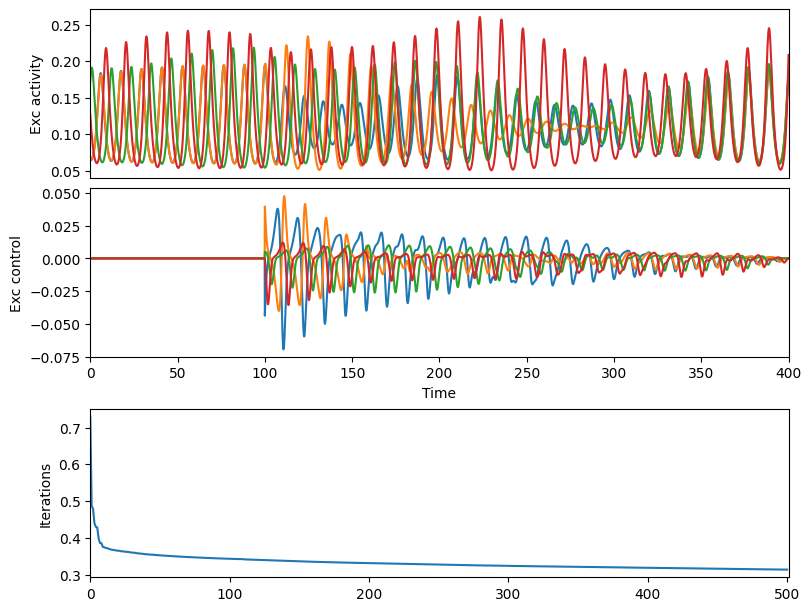

In [27]:
# We load the optimal control class
# print array (optional parameter) defines, for which iterations intermediate results will be printed
# Parameters will be taken from the input model
model_controlled = oc_wc.OcWc(model, 0, print_array=np.arange(0,501,25), control_matrix=control_mat, cost_matrix=cost_mat, control_interval=(1000, None), cost_interval=(1000, None))
model_controlled.weights["w_p"] = 0.
model_controlled.weights["w_2"] = 1.
model_controlled.weights["w_var"] = 1.

# We run 500 iterations of the optimal control gradient descent algorithm
model_controlled.optimize(500)

state = model_controlled.get_xs()
control = model_controlled.control

plot_osc_nw(duration, dt, state, control, N, cost_array=model_controlled.cost_history)

In [155]:
# Do another 500 iterations if you want to.
# Repeated execution will continue with further 100 iterations.
model_controlled.print_array=np.arange(0,5001,500)
model_controlled.channelwise_optimization = True
model_controlled.weights["w_2"] = 1e-8
model_controlled.grad_method =1

model_controlled.optimize(1000)
state = model_controlled.get_xs()
control = model_controlled.control
plot_osc_nw(duration, dt, state, control, N, cost_array=model_controlled.cost_history)

Compute control for a deterministic system
Cost in iteration 0: 0.5119570724900404


In [140]:
control_var = model_controlled.control.copy()